# **Segmentação de Clientes**



##**1. Entendimento do Problema**

Neste projeto, o foco será a segmentação de
clientes, com o objetivo de realizar campanhas mais direcionadas a públicos específicos que apresentam maior probabilidade de consumir determinado produto, serviço ou oferta. Dessa forma, conseguimos reduzir o custo de aquisição de clientes (CPA), já que aumentamos as chances de conversão.

A aplicação desse modelo tem como principais propósitos:

  1) Segmentação de mercado: dividir os clientes em grupos com características e comportamentos semelhantes;

  2) Definição do público-alvo: identificar os consumidores mais adequados para a marca, analisando o potencial de lucro de cada grupo, o tamanho atual, as perspectivas de crescimento e a atuação da concorrência;

  3) Posicionamento da oferta: ajustar a forma como cada produto será comunicado e apresentado a cada segmento de clientes.

Portanto, este projeto busca realizar a segmentação de clientes, oferecendo informações que servirão de apoio às estratégias de marketing e ao desenvolvimento de produtos. O resultado esperado é um aumento no faturamento da empresa, aliado a campanhas mais eficientes e personalizadas.

**1.1. Base de dados**

A base de dados utilizada neste trabalho será a base de "Mall Customer Segmentation", disponibilizado na plataforma Kaggle.

O dataset contém informações de uma carteira de clientes de uma loja, contando com 200 linhas representando, cada uma, um registro de cliente diferentes, e 7 colunas, representando variáveis.

As variáveis são:
  - CustomerID: identificação de cada cliente;
  - Gender: Male ou Female;
  - Age: idade do cliente;
  - Annual Income (k$): renda anual do cliente;
  - Spending Score (1-100): pontuação de gastos do cliente. Esse score é atribuído pelo shopping com base no comportamento do cliente e na natureza de seus gastos.

##**2. Análise Exploratória dos Dados**




**2.1. Importar bibliotecas e base de dados**

In [ ]:
# Importar as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage

import pickle

import warnings
import os
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Importar dataset de clientes
datapath = '/content/drive/MyDrive/Colab Notebooks/Projetos/Clusterizacao_Clientes/Dados/Mall_Customers.csv'

df = pd.read_csv(datapath)
df.shape


(200, 5)

**2.2. Visualização dos Dados**

Após importar a base de dados, vamos visualizá-los para entendermos melhor suas características.

A partir da visualização de algumas linhas, features, tipos de variáveis, valores ausentes/nulos e valores únicos em cada variável, é possível verificar que:

  - Os tipos de variáveis estão condizentes com seus valores no dataset, mas é necessário ajustar a variável "gênero" para que passe de categórica para numérica, através de um enconding. Essa alteração é necessária para que a variável fique adequada ao modelo K-Means.

  - Não há valores nulos ou ausentes.

  - A variável CustomerID não apresenta valores repitidos, com isso, podemos considerar esta coluna como índice de dataset.

  - Para facilitar a segmentação, vamos alterar os nomes ds colunas:
  
      - Annual Income (k$) para Income;
      - Spending Score (1-100) para Score.

In [ ]:
#visualizar as 5 primeiras linhas do dataset
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
#visualizar 5 últimas linhas do dataset
df.tail()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18
199,200,Male,30,137,83


In [ ]:
# Verificar tipos de variáveis.
print( '-> Tipos de variáveis:\n{}\n'.format( df.dtypes ) )

# Verificar valores nulos ou ausentes.
print( '-> Valores nulos ou ausentes em cada variável:\n{}\n'.format( df.isnull( ).sum( ) ) )
print( df.info( ) )

# Verificar os nomes das variáveis.
print( '\n-> Nome das variáveis:\n{}'.format( df.columns ) )

# Verificar valores únicos em cada variável.
print( '\n-> Valores únicos em cada variável:\n{}'.format( df.nunique( ) ) )


-> Tipos de variáveis:
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

-> Valores nulos ou ausentes em cada variável:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

-> Nome das variáveis:
Index(['CustomerID', 'Gender', 'Age', 'Annual Inc

In [ ]:
# Alterar nome das colunas 'Annual Income (k$)' e 'Spending Score (1-100)'
df.rename( columns = { 'Annual Income (k$)': 'Income_k$',
                      'Spending Score (1-100)': 'Score'}, inplace = True)


In [ ]:
df.head()

,CustomerID,Gender,Age,Income_k$,Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


**2.3. Descrição Estatística e Presença de Outiliers**

A partir da projeção de alguns gráficos, é possível verificar que o dataset não conta com valores discrepantes (outliers).

Além disso, vefiricamos que:

  - A média de "Age" dos clientes é cerca de 39 anos. O cliente mais novo registrado tem 18 anos e o mais velho 70 anos.

  - A média de "Income" dos clientes é cercade 60k. O cliente que recebe menor valor, tem salário de 15k e quem recebe mais, tem salário de 137k$.

  - Já o "Score" médio dos clientes representa um valor de 50.

In [ ]:
df[['Age', 'Income_k$', 'Score']].describe()

,Age,Income_k$,Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


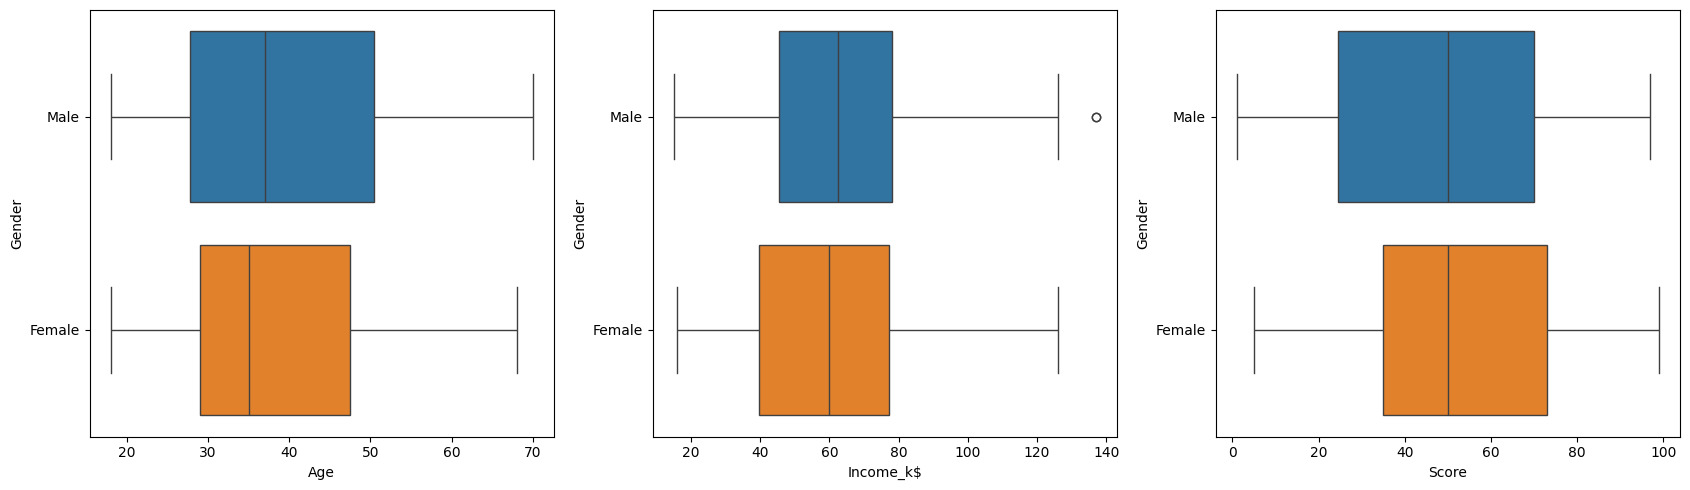

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(17,5))

sns.boxplot(data=df, x='Age', y='Gender', hue='Gender', ax=ax[0])
sns.boxplot(data=df, x='Income_k$', y='Gender', hue='Gender', ax=ax[1])
sns.boxplot(data=df, x='Score', y='Gender', hue='Gender', ax=ax[2])

plt.tight_layout()



**2.4. Pair Plot**

O pair plot foi aplicado na fase de análise exploratória de dados, com o objetivo de tornar mais clara a interpretação das relações entre as variáveis numéricas do conjunto de dados.

Essa forma de visualização constrói uma matriz de diagramas de dispersão que relaciona todos os pares de variáveis e, na diagonal, apresenta histogramas ou curvas de densidade, evidenciando a distribuição de cada atributo de maneira individual.

Com isso, é possível:

  - Identificar padrões, correlações e outliers;

  - Explorar a distribuição das variáveis de forma intuitiva;

  - Observar a formação de possíveis grupos (clusters);

  - Comparar as variáveis em relação a categorias específicas, usando a opção hue.

Esse recurso foi essencial para entender melhor os dados antes da aplicação do algoritmo de clusterização K-Means.

Com base na análise, verificamos que:

  - Existe um comportamento na relação entre Income_k$ e Score, sugerindo a presença de um possível padrão de consumo.

  - No gráfico Age x Score, observa-se que clientes com score acima de 60 concentram-se, em sua maioria, na faixa etária de 20 a 40 anos.


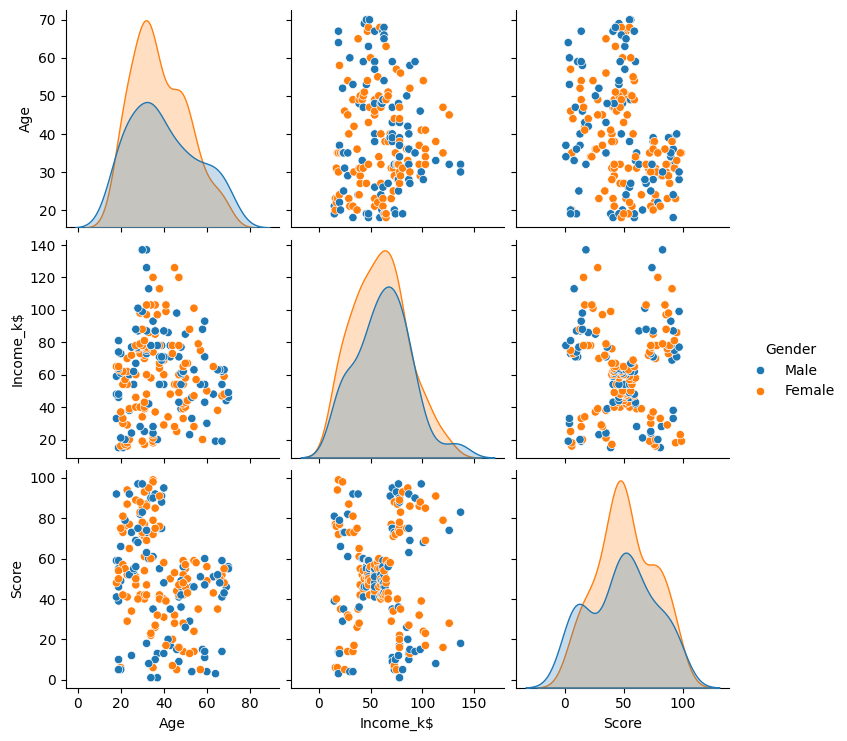

In [ ]:
sns.pairplot(df[['Gender','Age','Income_k$', 'Score']], hue='Gender');


**2.5. Count Plot**

O Count Plot é usado para visualizar a contagem de observações em cada categoria de uma variável categórica.

Ao analisar a distribuição dos clientes de cada gênero, verifica-se que 56% dos clientes analisados são do gênero feminino.

A distribuição de entradas da variável `Gender` é:
Gender
Female    112
Male       88
Name: count, dtype: int64



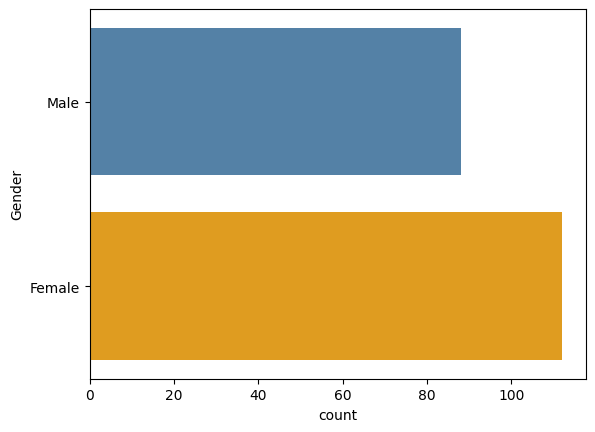

In [ ]:
sns.countplot(y=df['Gender'], palette={'Male': 'steelblue', 'Female': 'orange'})

print('A distribuição de entradas da variável `Gender` é:\n{}\n'.format(df['Gender'].value_counts()))


**2.6. Histogramas**

 Plotamos histogramas para visualizar a distribuição de uma variável numérica, mostrando como os valores se distribuem em intervalos (bins). Os histogramas plotados indicam um comportamento de curvas gaussianas.

 **2.6.1. Age (Idade)**

  - Distribuição relativamente ampla, indo de ~18 até 70 anos.

  - Maior concentração entre 25 e 40 anos, indicando que a base é formada principalmente por clientes adultos jovens.

  - Há uma baixa representatividade de clientes com mais de 60 anos, indicando que o segmento sênior é reduzido.

**2.6.2. Income_k$ (Renda Anual)**

  - Distribuição levemente simétrica, com mais clientes entre 40k e 80k.

  - Extremidades (rendimentos muito baixos ou muito altos) têm menos observações. Isso sugere que a maioria dos clientes está na classe média em termos de renda.

**2.6.3. Score (Spending Score)**

  - Distribuição bem espalhada, mas com concentrações visíveis em torno de 40–60 e também próximo de 80–90. Isso indica diferentes perfis de consumo: clientes que gastam pouco, clientes “médios” e clientes que gastam muito.

  - O Score parece ser o atributo mais promissor para distinguir segmentos de clientes.

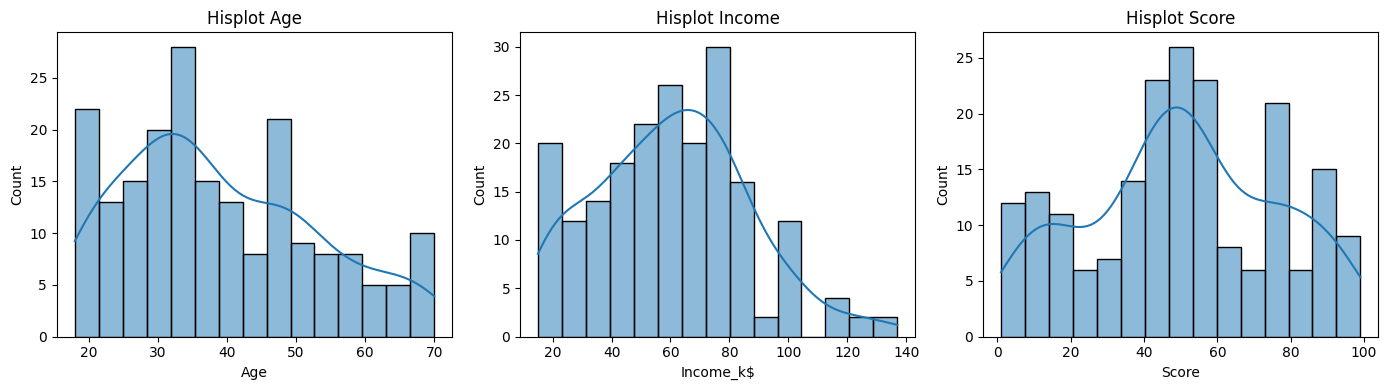

In [ ]:
fig, ax = plt.subplots( ncols=3, nrows=1, figsize=(14,4));

sns.histplot(data=df, x='Age', bins = 15, kde=True, ax=ax[0]);
ax[0].set_title('Hisplot Age')

sns.histplot(data=df, x='Income_k$', bins = 15, kde=True, ax=ax[1]);
ax[1].set_title('Hisplot Income')

sns.histplot(data=df, x='Score', bins = 15, kde=True, ax=ax[2]);
ax[2].set_title('Hisplot Score')

plt.tight_layout()


**2.7. Correlação**

A análise de correlação foi feita para entender o relacionamento entre as variáveis numéricas (Age, Income e Score). Essa etapa é importante para:

  - Identificar se existe redundância de variáveis (variáveis muito correlacionadas carregam a mesma informação).
  - Verificar se uma variável pode influenciar diretamente outra.
  - Orientar a escolha de atributos no modelo de clusterização, evitando incluir variáveis que não agregam valor.

Existe uma correlação negativa entre Age e Score. Isso sugere que clientes mais velhos tendem a ter Scores mais baixos, enquanto clientes mais jovens costumam ter Scores mais altos.

Esse comportamento pode sugerir que: jovens podem representar um perfil de clientes mais engajados/ativos para o comércio analisado.

Isso pode ser útil na definição de estratégias de marketing (ex.: campanhas específicas para clientes mais velhos visando aumentar engajamento).

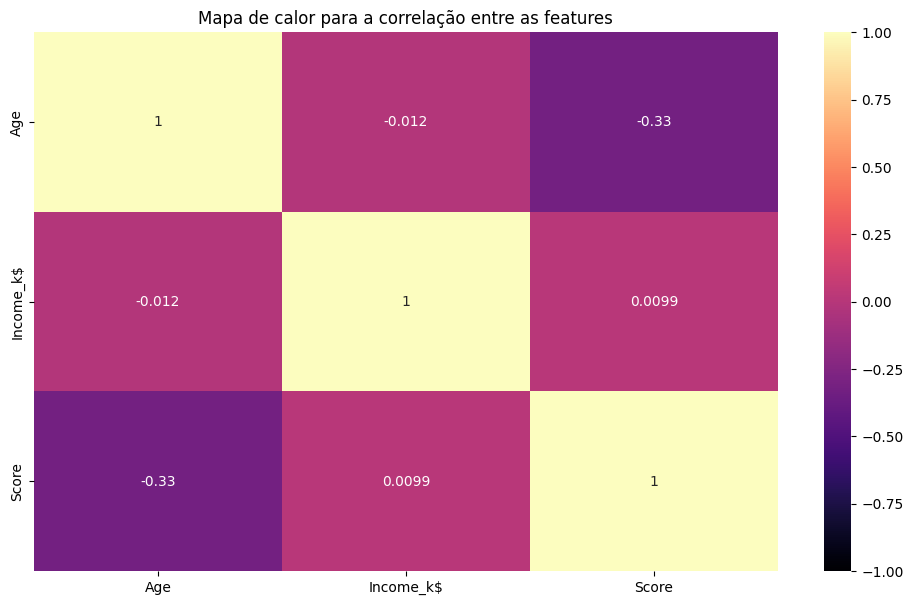

In [ ]:
# Mapa de calor para a correlação
plt.figure(figsize = (12, 7))
sns.heatmap(df[['Age','Income_k$', 'Score']].corr(),
            vmin = -1, vmax = 1, cmap = 'magma', annot = True)
plt.title("Mapa de calor para a correlação entre as features")
plt.show()



##**3. Preparação dos Dados**



Conforme visto anteriormente, o dataset não exige grandes ajustes.

Para a etapa de preparação dos dados, serão realizadas as seguintes ações:

  - Ajustar a variável Customer ID para o índice do dataframe
  - Aplicar o encoding na coluna Gender, atribuindos os seguintes valores:
      - Male == 1
      - Female == 0



In [ ]:
df_prep = df.copy()

# Alterar coluna CustomerID para index
df_prep.set_index('CustomerID', inplace = True)

# Encoding da coluna Gender, sendo que 0 == Female e 1 == Male
df_prep['Gender'] = df_prep['Gender'].replace(['Female', 'Male'], ['0', '1'])
df_prep['Gender'] = df_prep['Gender'].astype(str).astype(int)
df_prep.head()

,Gender,Age,Income_k$,Score
CustomerID,,,,
1,1,19,15,39
2,1,21,15,81
3,0,20,16,6
4,0,23,16,77
5,0,31,17,40


##**4. Construção do Modelo**


Nesta etapa, os principais objetivos são:
  1) Treinar diferentes modelos e comparar seus desempenhos;
  2) Identificar as variáveis mais relevantes para cada algoritmo;
  3) Realizar o ajuste fino (fine-tuning) dos hiperparâmetros;
  4) Aplicar cross-validation para avaliar a robustez dos modelos;
  5) Testar métodos de Ensemble, combinando os modelos com melhor desempenho individual;
  6) Avaliar a performance final utilizando o conjunto de teste.

**4.1. Cluster hierárquico**

O cluster hierárquico é utilizado para explorar a estrutura dos dados, identificar relações de proximidade e apoiar a segmentação de clientes de forma mais visual e interpretável.

Essa técnica é adequada para o nosso caso, já que o DataFrame possui apenas 200 registros. Ainda assim, também aplicaremos o K-Means para comparar os resultados obtidos.

**4.1.1. Dendograma**

Número de clusters: Ao observar o eixo das distâncias (Y), percebe-se que os maiores "saltos" acontecem por volta de 350–400. Isso indica que um bom corte no dendrograma está nessa altura, resultando em três grandes clusters (laranja, verde e vermelho).

Estrutura dos grupos:

  - Cluster 1 (laranja): é o mais numeroso, formado por clientes que apresentam características mais homogêneas entre si.

  - Cluster 2 (verde): é um grupo mais compacto, sugerindo que os clientes desse segmento são bastante semelhantes.

  - Cluster 3 (vermelho): também forma um grupo bem definido, mas com maior variabilidade interna do que o verde.

Distância entre clusters: Os clusters verde e vermelho estão mais próximos entre si do que em relação ao cluster laranja.Isso sugere que os clientes do verde e vermelho compartilham algumas características semelhantes, enquanto os do laranja se diferenciam mais.

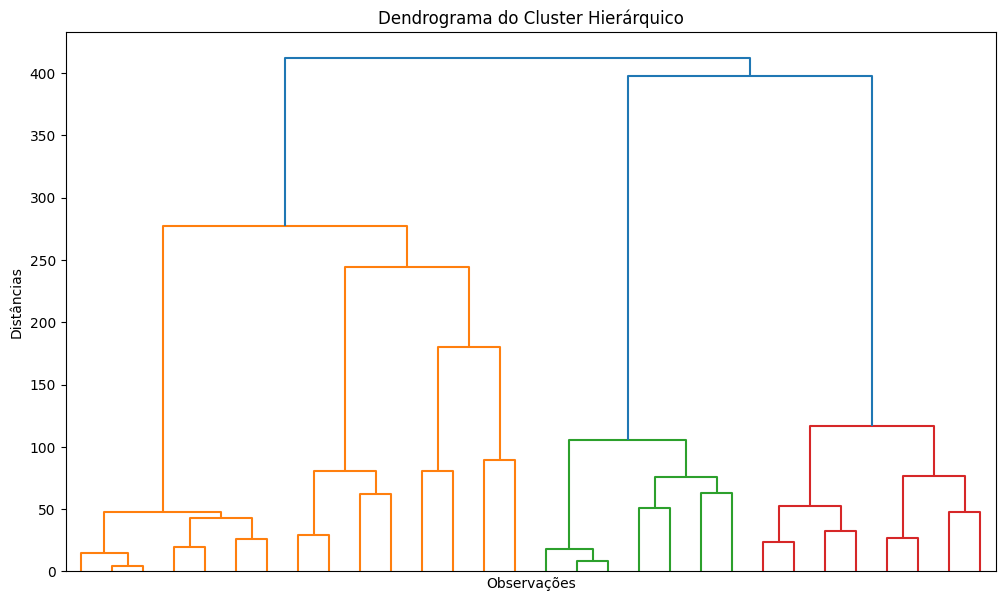

In [ ]:
# Fazendo o clustering
hier_cluster = linkage(df_prep, method = 'ward')

# Plotando o dendrograma
plt.figure(figsize = (12, 7))
dendrogram(hier_cluster,
           show_leaf_counts = False,
           truncate_mode = 'level',
           p = 4,
           no_labels = True)
plt.title("Dendrograma do Cluster Hierárquico")
plt.xlabel("Observações")
plt.ylabel("Distâncias")
plt.show();


**4.2. Cluster com algoritmo K-Means**

O K-Means é um dos algoritmos mais utilizados para tarefas de segmentação de clientes, pois agrupa observações semelhantes em clusters de acordo com suas características.

Seu funcionamento é baseado na ideia de minimizar a distância entre cada ponto e o centróide de seu cluster, tornando os grupos mais coesos internamente.

Vantagens

  1) Simples de implementar e interpretar.

  2) Muito eficiente para segmentações com dados bem distribuídos.

  3) Permite identificar grupos distintos de clientes e padrões de comportamento.

Apesar de ser bastante eficaz, o K-Means possui algumas limitações:

  1) Sensibilidade a outliers: como o algoritmo minimiza a distância euclidiana, pontos muito distantes podem distorcer os centróides.

  2) Alternativa: usar K-Median clustering, que é mais robusto, porém computacionalmente mais caro.

  3) Número de clusters (K) deve ser definido antes da análise: isso pode levar a resultados incorretos se não for escolhido adequadamente.

Escolha do número de clusters: para determinar o valor idealde K, serão utilizados:

  1) WCSS (Within- Cluster Sum Of Squares): mede a variação interna dentro dos clusters.
  2) Silhouette Socer: avalia a quantidade da separação entre os clusters.

Para analisar em quais combinações de colunas os clusters apresentam melhor desempenho, os métodos de avaliação serão aplicados nas colunas:

  1) Age, Score e Income_k$;

  2) Score e Income_k$.



**4.2.1. Análise Age, Score, Income**

In [ ]:
# Seleção das colunas
X_age_score_income = df_prep[['Age', 'Score', 'Income_k$']]

# Padronização para colocar tudo na mesma escala
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_age_score_income)

# Listas para armazenar resultados
wcss_age_score_income = []
silhouette_values_age_score_income = []

# Loop para testar diferentes K
for i in range(3, 9):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    wcss_age_score_income.append(kmeans.inertia_)
    silhouette = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_values_age_score_income.append(silhouette)


Gráfico do coeficiente de Coeficiente de Silhouette x Número de Clusters e Inércia x Número de Clusters


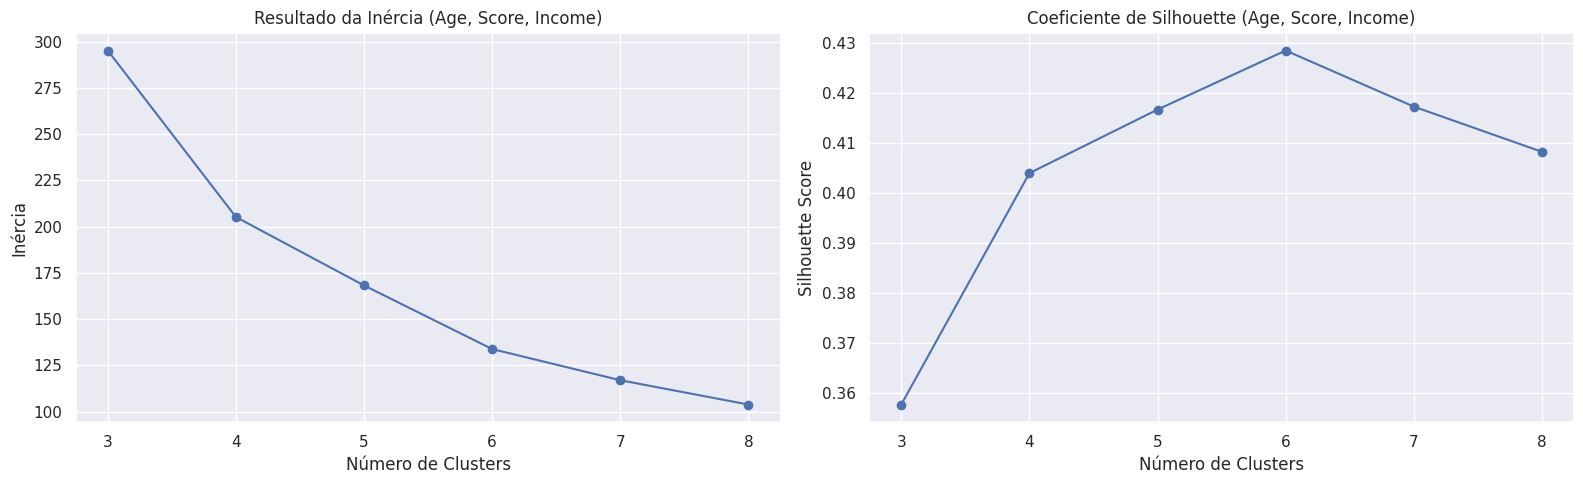

Para n_clusters = 3, Silhouette Score = 0.358
Para n_clusters = 4, Silhouette Score = 0.404
Para n_clusters = 5, Silhouette Score = 0.417
Para n_clusters = 6, Silhouette Score = 0.428
Para n_clusters = 7, Silhouette Score = 0.417
Para n_clusters = 8, Silhouette Score = 0.408


In [ ]:
# Configuração do estilo
sns.set()

# Criação dos subplots
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 5))

# Elbow Method
ax[0].plot(range(3, 9), wcss_age_score_income, marker='o')
ax[0].set_title('Resultado da Inércia (Age, Score, Income)')
ax[0].set_xlabel('Número de Clusters')
ax[0].set_ylabel('Inércia')

# Silhouette Score
ax[1].plot(range(3, 9), silhouette_values_age_score_income, marker='o')
ax[1].set_title('Coeficiente de Silhouette (Age, Score, Income)')
ax[1].set_xlabel('Número de Clusters')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Mostrar os valores de Silhouette no console
for i, val in enumerate(silhouette_values_age_score_income, start=3):
    print(f"Para n_clusters = {i}, Silhouette Score = {val:.3f}")



**4.2.2. Análise Score, Income**

In [ ]:

# Seleção das colunas (apenas Score e Income)
X_score_income = df_prep[['Score', 'Income_k$']]

# Padronização para colocar tudo na mesma escala
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_score_income)

# Listas para armazenar resultados
wcss_score_income = []
silhouette_values_score_income = []

# Loop para testar diferentes K
for i in range(3, 9):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    wcss_score_income.append(kmeans.inertia_)
    silhouette = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_values_score_income.append(silhouette)


Gráfico do coeficiente de Coeficiente de Silhouette x Número de Clusters e Inércia x Número de Clusters


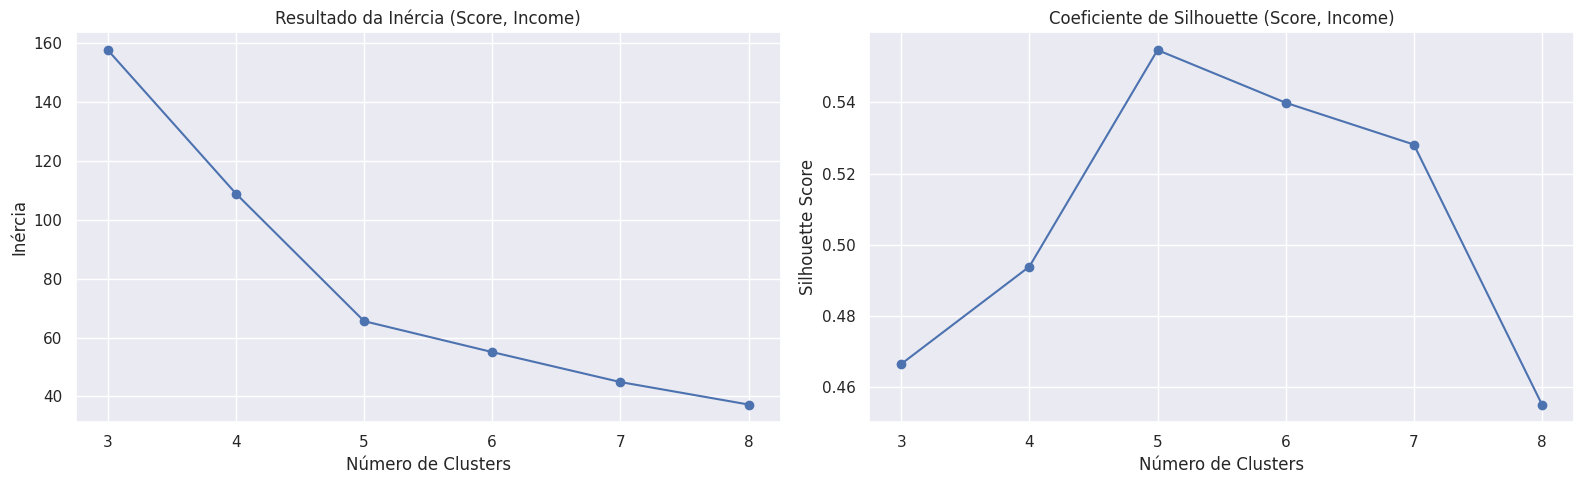

Para n_clusters = 3, Silhouette Score = 0.467
Para n_clusters = 4, Silhouette Score = 0.494
Para n_clusters = 5, Silhouette Score = 0.555
Para n_clusters = 6, Silhouette Score = 0.540
Para n_clusters = 7, Silhouette Score = 0.528
Para n_clusters = 8, Silhouette Score = 0.455


In [ ]:
sns.set()

# Criação dos subplots
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 5))

# Elbow Method
ax[0].plot(range(3, 9), wcss_score_income, marker='o')
ax[0].set_title('Resultado da Inércia (Score, Income)')
ax[0].set_xlabel('Número de Clusters')
ax[0].set_ylabel('Inércia')

# Silhouette Score
ax[1].plot(range(3, 9), silhouette_values_score_income, marker='o')
ax[1].set_title('Coeficiente de Silhouette (Score, Income)')
ax[1].set_xlabel('Número de Clusters')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Mostrar valores de Silhouette no console
for i, val in enumerate(silhouette_values_score_income, start=3):
    print(f"Para n_clusters = {i}, Silhouette Score = {val:.3f}")


A partir da visualização dos gráficos e da análise dos Silhouette Scores, observa-se que:

  - Income + Score: apresentou melhores médias de Silhouette, atingindo um valor máximo próximo de 0.55 em K=5. Isso indica uma segmentação mais clara e bem definida dos clientes, sendo a configuração de 5 clusters a mais adequada para este caso.

  - Age + Income + Score: embora tenha permitido incluir mais uma dimensão na análise, os valores de Silhouette foram mais baixos (máximo em torno de 0.43 em K=6). Isso mostra que a variável Age não contribui de forma significativa para a separação dos clusters, tornando a segmentação menos eficiente.

A análise considerando apenas Income e Score se mostrou mais robusta para segmentar os clientes, com K=5 sendo o número ótimo de clusters. A inclusão da variável Age adiciona ruído e reduz a qualidade da clusterização.

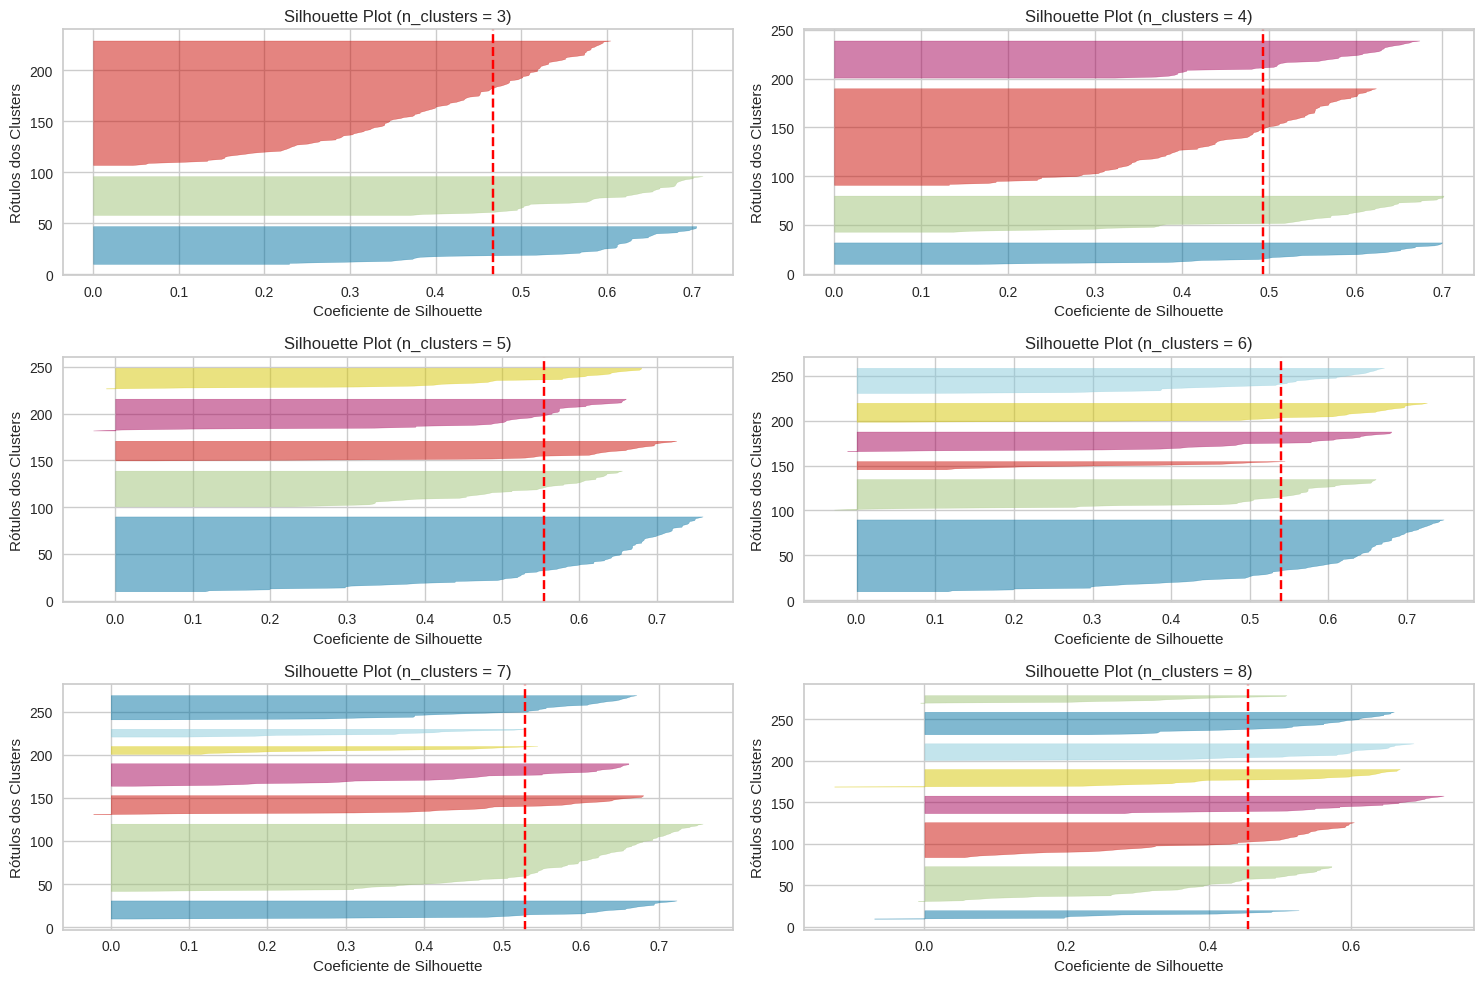

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

# Criar subplots: 3 linhas x 2 colunas (para clusters de 3 a 8)
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))

for i in range(3, 9):
    # Instância do KMeans
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)

    # Posição do subplot
    quotient, remainder = divmod(i-3, 2)

    # Visualização do Silhouette
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[quotient][remainder])
    visualizer.fit(X_scaled)  # <-- usa os dados já padronizados

    # Ajustar títulos e labels
    ax[quotient][remainder].set_title(f"Silhouette Plot (n_clusters = {i})")
    ax[quotient][remainder].set_xlabel("Coeficiente de Silhouette")
    ax[quotient][remainder].set_ylabel("Rótulos dos Clusters")

plt.tight_layout()



In [ ]:
# Treinar o modelo e fazer cluster de segmentação dos clientes
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X_scaled)
y_pred


array([4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2,
       4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 0,
       4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 1, 3, 1, 3, 1,
       0, 1, 3, 1, 3, 1, 3, 1, 3, 1, 0, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1], dtype=int32)

In [ ]:
# Centróides na escala padronizada
centroids_scaled = kmeans.cluster_centers_

# Inverter a padronização para trazer de volta à escala original
centroids = scaler.inverse_transform(centroids_scaled)

# Transformar em DataFrame para facilitar visualização
centroids_df = pd.DataFrame(centroids, columns=['Score', 'Income_k$'])
print("Posição dos centróides de cada cluster (em valores originais):")
print(centroids_df)


Posição dos centróides de cada cluster (em valores originais):
       Score  Income_k$
0  49.518519  55.296296
1  82.128205  86.538462
2  79.363636  25.727273
3  17.114286  88.200000
4  20.913043  26.304348


In [ ]:
# Copiar base de dados para incluir coluna de clusters
df_seg = df_prep.copy()

# Incluir coluna de clusters no dataset
df_seg['Cluster'] = y_pred
df_seg.head()


,Gender,Age,Income_k$,Score,Cluster
CustomerID,,,,,
1,1,19,15,39,4
2,1,21,15,81,2
3,0,20,16,6,4
4,0,23,16,77,2
5,0,31,17,40,4


**Análise dos Clusters**

- A segmentação revelou 5 perfis distintos de clientes:

  - Cluster 0 (40,5%): maioria feminina, idade média de 43 anos, renda e score medianos. Representa o grupo “regular” da base.

  - Cluster 1 (19,5%): clientes estratégicos, jovens-adultos, renda alta (86k) e score elevado (82).

  - Cluster 2 (11,0%): clientes em potencial, jovens com baixa renda (26k), mas alto score (79).

  - Cluster 3 (17,5%): homens, renda alta (88k) porém score muito baixo (~17). Baixa prioridade.

  - Cluster 4 (11,5%): clientes mais velhos, renda e score baixos. Pouco atrativos.

Conclusão: Clusters 1 e 2 são os mais valiosos, Cluster 0 é o grupo de base, enquanto Clusters 3 e 4 têm baixo engajamento.

In [ ]:
import pandas as pd

# Total de clientes
total_clientes = len(df_seg)

# Agrupar por cluster
resumo_clusters = df_seg.groupby('Cluster').agg({
    'Gender': lambda x: x.value_counts().index[0],  # gênero predominante
    'Age': 'mean',
    'Income_k$': 'mean',
    'Score': 'mean',
    'Cluster': 'count'
}).rename(columns={
    'Gender': 'Gênero predominante',
    'Age': 'Idade média',
    'Income_k$': 'Renda média (k$)',
    'Score': 'Score médio',
    'Cluster': 'Qtd clientes'
})

# Calcular proporção (%) de cada cluster
resumo_clusters['Proporção (%)'] = (resumo_clusters['Qtd clientes'] / total_clientes * 100).round(1)

# Resetar índice para exibir bonitinho
resumo_clusters = resumo_clusters.reset_index()

resumo_clusters


,Cluster,Gênero predominante,Idade média,Renda média (k$),Score médio,Qtd clientes,Proporção (%)
0,0,0,42.716049,55.296296,49.518519,81,40.5
1,1,0,32.692308,86.538462,82.128205,39,19.5
2,2,0,25.272727,25.727273,79.363636,22,11.0
3,3,1,41.114286,88.200000,17.114286,35,17.5
4,4,0,45.217391,26.304348,20.913043,23,11.5


**Gráfico de Dispersão**

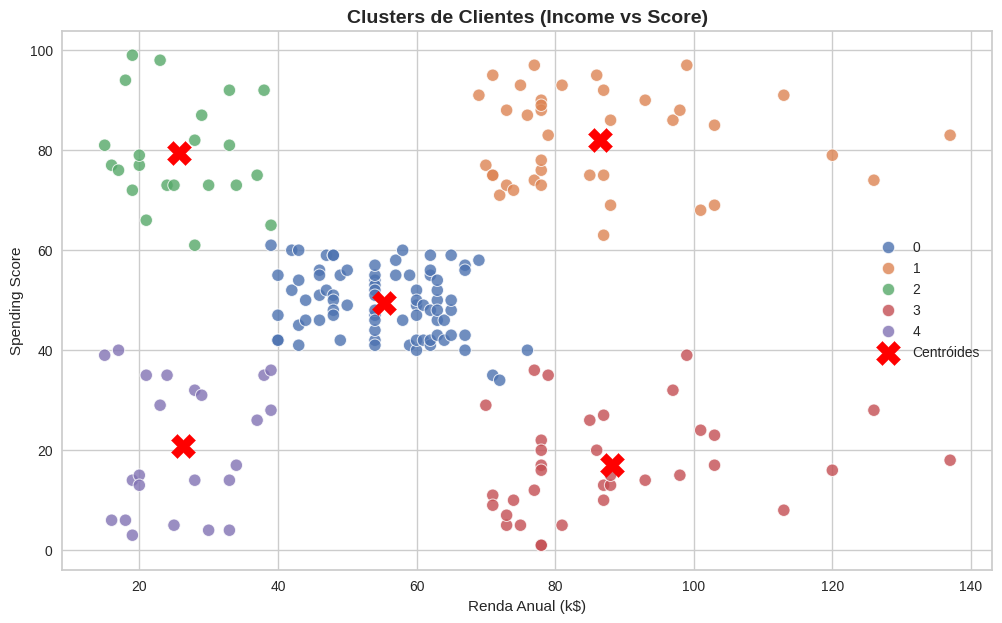

In [ ]:
# Plotando o resultado em um gráfico de dispersão com centróides
plt.figure(figsize=(12, 7))

# Scatterplot dos clientes
sns.scatterplot(
    data=df_seg,
    x="Income_k$",
    y="Score",
    hue="Cluster",
    s=80,
    palette="deep",
    alpha=0.8
)

# Plotar centróides (em escala original)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(
    centroids[:, 1],  # Income (2ª coluna)
    centroids[:, 0],  # Score (1ª coluna)
    s=300,
    c="red",
    marker="X",
    label="Centróides"
)

# Ajustes visuais
plt.title("Clusters de Clientes (Income vs Score)", fontsize=14, fontweight="bold")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Spending Score")
plt.legend()
plt.show()

##**5. Apresentação da Solução e Deploy**

Agora vamos testar em três novos clientes:

  - Cliente A: renda = 40k, score = 60

  - Cliente B: renda = 90k, score = 20

  - Cliente C: renda = 70k, score = 85

In [ ]:
# Novos clientes (Score, Income)
novos_clientes = pd.DataFrame({
    'Score': [60, 20, 85],
    'Income_k$': [40, 90, 70]
})

# Padronizar usando o mesmo scaler treinado
novos_clientes_scaled = scaler.transform(novos_clientes)

# Prever clusters
clusters_previstos = kmeans.predict(novos_clientes_scaled)

# Resultado
novos_clientes['Cluster_Previsto'] = clusters_previstos
print(novos_clientes)


   Score  Income_k$  Cluster_Previsto
0     60         40                 0
1     20         90                 3
2     85         70                 1


**5.1. Exportação de Dados com Pickle**


In [ ]:
#Instância do K-Means
pickle.dump(kmeans, open("kmeans.pickle", "wb"))
